<h1 style="text-align:center">Data Science and Machine Learning Capstone Project</h1>
<img style="float:right" src="https://prod-edxapp.edx-cdn.org/static/edx.org/images/logo.790c9a5340cb.png">
<p style="text-align:center">IBM: DS0720EN</p>
<p style="text-align:center">Question 3 of 4</p>

1. [Problem Statement](#problem)
2. [Question 3](#question)
3. [Data Cleaning and Standardization](#wrangling)
4. [Analyzing and Visualizing](#analysis)
5. [Concluding Remarks](#conclusion)

<a id="problem"></a>
# Problem Statement
---

The people of New York use the 311 system to report complaints about the non-emergency problems to local authorities. Various agencies in New York are assigned these problems. The Department of Housing Preservation and Development of New York City is the agency that processes 311 complaints that are related to housing and buildings.

In the last few years, the number of 311 complaints coming to the Department of Housing Preservation and Development has increased significantly. Although these complaints are not necessarily urgent, the large volume of complaints and the sudden increase is impacting the overall efficiency of operations of the agency.

Therefore, the Department of Housing Preservation and Development has approached your organization to help them manage the large volume of 311 complaints they are receiving every year.

The agency needs answers to several questions. The answers to those questions must be supported by data and analytics. These are their  questions:

<a id="question"></a>
# Question 3
---

Does the Complaint Type that you identified in response to Question 1 have an obvious relationship with any particular characteristic or characteristic of the Houses?

## Approach
Determine whether or not there are any correlations between the building characteristics of buildings that experienced HEAT/HOT WATER complaints (from Question 1) relative to the building characteristics of all buildings in the PLUTO house database.

## Load Data
Separately from this notebook:

The [New York 311](https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9) data was loaded by [SODA](https://data.cityofnewyork.us/resource/fhrw-4uyv.csv?$limit=100000000&Agency=HPD&$select=created_date,unique_key,complaint_type,incident_zip,incident_address,street_name,address_type,city,resolution_description,borough,latitude,longitude,closed_date,location_type,status) into a Pandas DataFrame then saved to a pickle file.

The [New York PLUTO](https://data.cityofnewyork.us/City-Government/Primary-Land-Use-Tax-Lot-Output-PLUTO-/xuk2-nczf) data was downloaded.  The instructions at ( Course / 1. Project Challenge Details and Setup / Datasets Used in this Course / Datasets ) said "Use only the part that is specific to the borough that you are interested in based on your analysis."  My answer for Question 2 suggested the borough with the biggest HEAT/HOT WATER problem was BRONX.  For that reason, only the BX_18v1.csv file was loaded into a Pandas DataFrame then saved to a pickle file

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import scipy.stats as stats
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import jaccard_score, classification_report, log_loss, confusion_matrix

files_path = 'C:\\Users\\It_Co\\Documents\\DataScience\\Capstone\\' #local
#files_path = './' #IBM Cloud / Watson Studio

In [ ]:
b311 = pd.read_pickle(files_path + 'ny311full.pkl')

#file_columns = ['Address','BldgArea','BldgDepth','BuiltFAR','CommFAR','FacilFAR','Lot','LotArea','LotDepth','NumBldgs','NumFloors','OfficeArea','ResArea','ResidFAR','RetailArea','YearBuilt','YearAlter1','ZipCode', 'YCoord', 'XCoord', 'BldgClass', 'LandUse']
#df = pd.read_csv(files_path + 'BX_18v1.csv', usecols=file_columns)
#df = pd.concat([df, pd.read_csv(files_path + 'BK_18v1.csv', usecols=file_columns)])
#df = pd.concat([df, pd.read_csv(files_path + 'MN_18v1.csv', usecols=file_columns)])
#df = pd.concat([df, pd.read_csv(files_path + 'QN_18v1.csv', usecols=file_columns)])
#df = pd.concat([df, pd.read_csv(files_path + 'SI_18v1.csv', usecols=file_columns)])
#df.to_pickle(files_path + 'q3.pkl')

df = pd.read_pickle(files_path + 'q3.pkl')

print("NY 311 shape %s" % (b311.shape,))
print("PLUTO shape %s" % (df.shape,))

In [ ]:
df.head()

<a id="wrangling"></a>
# Data Cleaning and Standardization
---

Correct or remove observations with missing or malformed data.  The 311 and the PLUTO data sets will need to be "joined" together by the common "address" element, which means the addresses will need to be standardized to a consistent layout to allow the addresses to be compared consistently.

## NY 311

### General

In [ ]:
#Remove columns deemed unnecessary for this question.
b311.drop(['created_date','street_name','address_type','resolution_description','closed_date','location_type','status','unique_key','latitude','longitude'], axis=1, inplace=True)
#Only use the combined "heating and hot water" complaints determined from Question 1.
b311['complaint_type'] = b311['complaint_type'].str.upper()
b311.drop(b311[b311["complaint_type"].isin(["HEAT/HOT WATER","HEATING"])==False].index, axis=0, inplace=True)
b311.reset_index(drop=True, inplace=True)
#Adjust all relevant strings to uppercase so different casing won't appear as separate values.
b311['incident_address'] = b311['incident_address'].str.upper()
b311['city'] = b311['city'].str.upper()
b311['borough'] = b311['borough'].str.upper()

In [ ]:
#Print some initial information for comparison during later steps.
print("shape %s" % str(b311.shape))
print("--nulls below--")
print(b311.isnull().sum())
print("--types below--")
print(b311.dtypes)
b311.head()

### Standardize Borough
Leveraging findings found while standardizing during Question 2.

In [ ]:
b311['borough'].value_counts()

In [ ]:
#Correct rows where borough was entered in the city column with "UNSPECIFIED" in the borough column.
five_boroughs = ["BROOKLYN","BRONX","MANHATTAN","QUEENS","STATEN ISLAND"]
which_rows_to_adjust = b311[(b311["borough"]=='UNSPECIFIED')&b311["city"].isin(five_boroughs)].index
b311.loc[which_rows_to_adjust,'borough']=b311.loc[which_rows_to_adjust,'city']
b311.loc[which_rows_to_adjust,'city']=np.nan
#Drop a few rows of ambiguous data.
b311.drop(b311[(b311["borough"]=='MANHATTAN')&(b311["city"]=='BRONX')].index, axis=0, inplace=True)
b311.reset_index(drop=True, inplace=True)
#Fill in UNSPECIFIED borough when city was entered as NEW YORK.
which_rows_to_adjust = b311[(b311["borough"]=='UNSPECIFIED')&(b311["city"]=='NEW YORK')].index
b311.loc[which_rows_to_adjust,'borough']="MANHATTAN"
b311.loc[which_rows_to_adjust,'city']=np.nan
#Although the city for most of the "NEW YORK" ones are the only ones that technically got the "city" column valued correctly,
#since every other row uses city as "neighborhood":  Standardize these.
which_rows_to_adjust = b311[(b311["city"]=='NEW YORK')].index
b311.loc[which_rows_to_adjust,'city']=np.nan
#Any still unspecified boroughs with a value in "city" are in the Queens borough.  The "city" is actually a "neighborhood".
queens_neighborhoods = b311[(b311['borough']=='UNSPECIFIED')&(b311['city'].isnull()==False)]['city'].unique()
#Standardize borough for Queens neighborhoods.
which_rows_to_adjust = b311[(b311["borough"]=='UNSPECIFIED')&b311["city"].isin(queens_neighborhoods)].index
b311.loc[which_rows_to_adjust,'borough']="QUEENS"
#Null the borough if it still shows up as unspecified borough as there is no other information from which to derive it.
which_rows_to_adjust = b311[(b311["borough"]=='UNSPECIFIED')&b311["city"].isnull()].index
b311.loc[which_rows_to_adjust,'borough']=np.nan

In [ ]:
b311['borough'].value_counts()

### Filter NY 311 data by borough to only include BRONX
The instructions at ( Course / 1. Project Challenge Details and Setup / Datasets Used in this Course / Datasets ) said "Use only the part that is specific to the borough that you are interested in based on your analysis."  My answer for Question 2 suggested the borough with the biggest HEAT/HOT WATER problem was BRONX.  For that reason, I am only considering the BRONX data.

In [ ]:
b311.drop(b311[(b311["borough"]!='BRONX')].index, axis=0, inplace=True)
b311.reset_index(drop=True, inplace=True)
b311['borough'].value_counts()

### Remove unnecessary rows

In [ ]:
# Drop observations with missing address as there will be no way to tie them to any PLUTO data.
b311.dropna(subset=['incident_address'], axis=0, inplace=True)
b311.reset_index(drop=True, inplace=True)
print(b311.isnull().sum())
b311['incident_address'].value_counts().head()

## BRONX PLUTO

In [ ]:
print("shape %s" % str(df.shape))
print("---isnull follows---")
print(df.isnull().sum())
df.head()

### General

In [ ]:
df.dtypes

In [ ]:
#Adjust relevant strings to uppercase so different casing won't appear as separate values.
df['Address'] = df['Address'].str.upper()

In [ ]:
# Drop the observations with missing address as there will be no way to tie them to any 311 data.
df.dropna(subset=['Address'], axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

In [ ]:
# Drop the observations with missing land use.
df.dropna(subset=['LandUse'], axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

## Standardization of Addresses
Leveraging standardization methods developed during question 2.

In [ ]:
print("BRONX 311 unique addresses: %s" % b311['incident_address'].unique().size)
print("BRONX PLUTO unique addresses: %s" % df['Address'].unique().size)

<p style="color:Red;">Determine how much overlap.  Ideally all 29K BRONX 311 addresses will be represented in the PLUTO set.</p>

In [ ]:
def WhichAddressesNotInPluto(howManyTopToShow):
    complaints = set(b311['incident_address'].unique())
    pluto = set(df['Address'].unique())
    #Determine which 311 addresses were not found in PLUTO to gain insight as to why.
    differences = complaints.difference(pluto)
    print("Records not in PLUTO: %s.  Percent: %s" % (len(differences), "{:.2%}".format(len(differences) / len(complaints))))
    print("---Top %i---" % howManyTopToShow)
    print(b311[b311['incident_address'].isin(differences)]['incident_address'].value_counts().head(howManyTopToShow))

In [ ]:
WhichAddressesNotInPluto(3)

<p style="color:Red;">Over 20 percent of addresses in the BRONX 311 data cannot be merged to the BRONX PLUTO data prior to standardization.</p>

### Borrow some python functions developed during question 2
With minor improvements to better work with full addresses instead of just street names.

In [ ]:
# Some street values have multiple spaces in a row.
import re
def standardize_spaces(raw):
    result = raw.strip() #Remove leading and trailing spaces.
    result = re.sub(' +', ' ', result) #Squeeze multiple adjacent spaces into just one space.
    return result

In [ ]:
# Some streets have problematic characters.  For example:  ST. ANN'S AVENUE also exists without period or apostophe.
problem_characters = ['.', '\'']
def replace_problem_characters(raw):
    result = raw
    for (character) in problem_characters:
        result = result.replace(character,'')
    return result

In [ ]:
#Some words are sometimes entered in a non-standard way or with typos need to be standardized.
word_replacements = [("AVE","AVENUE"),("ST","STREET"),("RD","ROAD"),("FT","FORT"),("BX","BRONX"),("MT","MOUNT"),
                     ("NICHLAS","NICHOLAS"),("NICHALOS","NICHOLAS"),("EXPRE","EXPRESSWAY"),("HARACE","HORACE"),
                     ("NO","NORTH"),("AV","AVENUE"),("CRK","CREEK"),("FR","FATHER"),("JR","JUNIOR"),("GR","GRAND"),
                     ("CT","COURT"),
                     ("SR",""), # Service Road.  These are always near a similarly named street.  Lump together.
                     ("QN","QUEENS"),
                     ("ND",""), # A space between a number and ND such as EAST 52 ND STREET.  Note ST and RD can be street or road.
                     ("PO","POND"),("BO","BOND"),("GRA","GRAND"),("REV","REVEREND"),("CO-OP","COOP"),
                     ("GRANDCONCOURSE", "GRAND CONCOURSE"),("CENTRL", "CENTRAL"),("BLVD","BOULEVARD"),
                     ("FREDRICK", "FREDERICK"),("DOUGLAS", "DOUGLASS"),("MALCOM", "MALCOMN"),
                     ("NORTHEN", "NORTHERN"),("AVNEUE","AVENUE"),
                    ("N","NORTH"),("S","SOUTH"),("E","EAST"),("W","WEST"),("SW","SOUTHWEST"),
                             ("NW","NORTHWEST"),("SE","SOUTHEAST"),("NE","NORTHEAST")]
def replace_words(raw):
    split_raw = raw.split()
    for (old, new) in word_replacements:
        found_at_index = next((i for i, x in enumerate(split_raw) if x==old), None)
        if found_at_index!=None:
            split_raw[found_at_index] = new
    return standardize_spaces(" ".join(split_raw))

In [ ]:
#Some words are actually prefixes of the following word.  Example the LA prefix of LA GRANGE.
word_prefixes = ["DE","MC","LA","VAN","MAC","CO"]
def concatenate_prefixes(raw):
    split_raw = raw.split()
    last_word = len(split_raw) - 1
    for (prefix) in word_prefixes:
        found_at_index = next((i for i, x in enumerate(split_raw) if x==prefix), None)
        if found_at_index!=None:
            if len(split_raw)>1:
                if found_at_index != last_word:
                    split_raw[found_at_index] = ''
                    split_raw[found_at_index+1] = prefix + split_raw[found_at_index+1]
                    return standardize_spaces(" ".join(split_raw))
    return raw

In [ ]:
#Some phrases need custom replacement because they involve multiple words or easily mis-interpretted out of context.
phrase_replacements = [("DR M L KING JR","MARTIN LUTHER KING"),("DR MARTIN L KING","MARTIN LUTHER KING"),
    ("MARTIN LUTHER KING","MARTIN LUTHER KING"),("MARTIN L KING JR","MARTIN LUTHER KING"),
    ("MARTIN L KING","MARTIN LUTHER KING"),("ST NICHOLAS","SAINT NICHOLAS"),("ST JOHN","SAINT JOHN"),
    ("ST MARK","SAINT MARK"),("ST ANN","SAINT ANN"),("ST LAWRENCE","SAINT LAWRENCE"),("ST PAUL","SAINT PAUL"),
    ("ST PETER","SAINT PETER"),("ST RAYMOND","SAINT RAYMOND"),("ST THERESA","SAINT THERESA"),("ST FELIX","SAINT FELIX"),
    ("ST MARY","SAINT MARY"),("ST OUEN","SAINT OUEN"),("ST JAMES","SAINT JAMES"),("ST GEORGE","SAINT GEORGE"),
    ("ST EDWARD","SAINT EDWARD"),("ST CHARLES","SAINT CHARLES"),("ST FRANCIS","SAINT FRANCIS"),
    ("ST ANDREW","SAINT ANDREW"),("ST JUDE","SAINT JUDE"),("ST LUKE","SAINT LUKE"),("ST JOSEPH","SAINT JOSEPH"),
    ("N D PERLMAN","NATHAN PERLMAN"),("O BRIEN","OBRIEN"),("F D R","FDR"),("EXPRESSWAY N SR","EXPRESSWAY SR N"),
    ("HOR HARDING","HORACE HARDING"),
    ("SERVICE ROAD",""), # These are always near a similarly named street. Lump together.
    ("DUMMY",""),("ADAM C POWELL","ADAM CLAYTON POWELL"),("POWELL COVE","POWELLS COVE")]
def replace_phrases(raw):
    result = raw
    for (old,new) in phrase_replacements:
        result = standardize_spaces(result.replace(old,new))
    return result

In [ ]:
# 1ST, 2ND, 3RD, 4TH, ... nTH
# Remove the suffixes leaving the numbers by themselves.
number_suffixes = ["ST","ND","RD","TH"]
digits=["1","2","3","4","5","6","7","8","9","0"]
def remove_number_suffixes(raw):
    split_raw = raw.split()
    for suffix in number_suffixes:
        found_at_index = next((i for i, x in enumerate(split_raw) if x[0] in digits and x.endswith(suffix)), None) 
        if found_at_index!=None:            
            split_raw[found_at_index] = split_raw[found_at_index][:-2]
            return standardize_spaces(" ".join(split_raw))
    return raw

In [ ]:
def standardize_street(street):
    r = street 
    r = standardize_spaces(r) 
    r = replace_problem_characters(r) 
    r = replace_phrases(r) 
    r = replace_words(r) 
    r = concatenate_prefixes(r) 
    r = remove_number_suffixes(r) 
    return r

### Standardize the address in both the 311 and PLUTO data

In [ ]:
b311['incident_address'] = b311['incident_address'].apply(standardize_street)

In [ ]:
df['Address'] = df['Address'].apply(standardize_street)

In [ ]:
# See if there was an improvement in how well the 311 data can be merged with the PLUTO data by address.
WhichAddressesNotInPluto(3)

<p style="color:Red;">The percentage of addresses in the 311 data that can be matched to an entry in the PLUTO data set improved measurably.</p>

In [ ]:
df.to_pickle(files_path + 'q3standardized.pkl')

## Imputation
Handling "missing" features.  That are null or have a zero placeholder instead of a "real" value.

In [ ]:
df = pd.read_pickle(files_path + 'q3standardized.pkl')

In [ ]:
def check_nulls():
    for col in df.columns:
        nulls = len(df[df[col].isnull()])
        if nulls > 0:
            print("%s:  %i of %i (%s)" % (col, nulls, df.shape[0], "{:.2%}".format(nulls / df.shape[0])))
check_nulls()

In [ ]:
#Replace with zeroes to kick these forward to the next section.
df['ZipCode'].replace(to_replace=np.nan, value=0, inplace=True)
df['XCoord'].replace(to_replace=np.nan, value=0, inplace=True)
df['YCoord'].replace(to_replace=np.nan, value=0, inplace=True)
check_nulls()

In [ ]:
def check_zeroes():
    for col in df.columns:
        zeroes = len(df[df[col].eq(0)])
        if zeroes > 0:
            print("%s:  %i of %i (%s)" % (col, zeroes, df.shape[0], "{:.2%}".format(zeroes / df.shape[0])))
check_zeroes()

In [ ]:
# Drop rows that have only a small number of zero values in a column.
df.drop(df[df["ZipCode"].eq(0)].index, axis=0, inplace=True)
df.drop(df[df["LotArea"].eq(0)].index, axis=0, inplace=True)
df.drop(df[df["LotDepth"].eq(0)].index, axis=0, inplace=True)
df.drop(df[df["BldgDepth"].eq(0)].index, axis=0, inplace=True)
df.drop(df[df["BuiltFAR"].eq(0)].index, axis=0, inplace=True)
df.drop(df[df["FacilFAR"].eq(0)].index, axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)
check_zeroes()

In [ ]:
# May need to drop more rows, that had columns with a lot of zeroes in multiple columns.
df.drop(df[df["NumBldgs"].eq(0)].index, axis=0, inplace=True)
df.drop(df[df["NumFloors"].eq(0)].index, axis=0, inplace=True)
df.drop(df[df["YearBuilt"].eq(0)].index, axis=0, inplace=True)
df.drop(df[df["XCoord"].eq(0)].index, axis=0, inplace=True)
df.drop(df[df["YCoord"].eq(0)].index, axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)
check_zeroes()

In [ ]:
df.head()

## Scaling, Centering

In [ ]:
df.columns

In [ ]:
def scale_and_center(column_name):
    scale=MinMaxScaler()
    scale.fit(df[[column_name]])
    df[[column_name]]=scale.transform(df[[column_name]])
#scale_and_center('LotArea')
#scale_and_center('BldgArea')
#scale_and_center('NumBldgs')
#scale_and_center('NumFloors')
#scale_and_center('LotDepth')
#scale_and_center('BldgDepth')
#scale_and_center('YearBuilt')
#scale_and_center('BuiltFAR')
#scale_and_center('FacilFAR')
#scale_and_center('XCoord')
#scale_and_center('YCoord')

#for f in df.columns:
#    scale_and_center(f)

In [ ]:
def scale_and_center_latent(column_name, latent):
    scale=MinMaxScaler()
    #scale.fit(df.loc[df[latent].eq(1), column_name].to_frame())
    df.loc[df[latent].eq(1), column_name] = scale.fit_transform(df.loc[df[latent].eq(1), column_name].to_frame())
#scale_and_center_latent('ResArea', 'IsResArea')
#scale_and_center_latent('OfficeArea', 'IsOfficeArea')
#scale_and_center_latent('RetailArea', 'IsRetailArea')
#scale_and_center_latent('YearAlter1', 'IsYearAlter1')
#scale_and_center_latent('ResidFAR', 'IsResidFAR')
#scale_and_center_latent('CommFAR', 'IsCommFAR')

In [ ]:
df.describe()

## Latent variables
Derived from the other data

### Add qualitative variables based on features with a lot of zeroes
Which may indicate they are missing instead of actually zero.

In [ ]:
df.insert(len(df.columns) - 1, 'IsResArea', df['ResArea'].ne(0).astype('int64'))
df.insert(len(df.columns) - 1, 'IsOfficeArea', df['OfficeArea'].ne(0).astype('int64'))
df.insert(len(df.columns) - 1, 'IsRetailArea', df['RetailArea'].ne(0).astype('int64'))
df.insert(len(df.columns) - 1, 'IsYearAlter1', df['YearAlter1'].ne(0).astype('int64'))
df.insert(len(df.columns) - 1, 'IsResidFAR', df['ResidFAR'].ne(0).astype('int64'))
df.insert(len(df.columns) - 1, 'IsCommFAR', df['CommFAR'].ne(0).astype('int64'))

In [ ]:
print(df['IsResArea'].value_counts())
print(df['IsOfficeArea'].value_counts())
print(df['IsRetailArea'].value_counts())
print(df['IsYearAlter1'].value_counts())
print(df['IsResidFAR'].value_counts())
print(df['IsCommFAR'].value_counts())

### Add qualitative variables based on Building Class
As they seem like an important "building characteristic" to consider.

In [ ]:
class_dummies = pd.get_dummies(df['BldgClass'].str.get(0), prefix="BuildingClass")
df = pd.concat([df, class_dummies], axis=1)

### Add qualitative variables based on Land Use
This seem like an important building (or property) characteristic to consider.

In [ ]:
class_dummies = pd.get_dummies(df['LandUse'].astype('int64'), prefix="LandUse")
df = pd.concat([df, class_dummies], axis=1)

### Variables to indicate "how many" and "if any" HEAT complaints at each address.
So that we can see if it correlates to anything else in the data.

In [ ]:
df.insert(0, 'IsComplaints', df['Address'].isin(b311['incident_address'].unique()).astype('int64'))
counts = b311['incident_address'].value_counts(sort=False).sort_index()
df.insert(1, 'Complaints', df['Address'].map(counts))
df['Complaints'].replace(to_replace=np.nan, value=0, inplace=True)

In [ ]:
#del b311 # Maybe save a little memory later

In [ ]:
print ("IsComplaints")
print(df['IsComplaints'].value_counts().head())
print ("Complaints")
print(df['Complaints'].value_counts().head())

## Drop columns no longer needed
Such as those only needed to derive latent variables.

In [ ]:
df.drop(['Lot','ZipCode','Address','XCoord','YCoord','BldgClass','LandUse'], axis=1, inplace=True)
df.head()

## Save the cleaned data.

In [ ]:
df.to_pickle(files_path + 'q3clean.pkl')

<p style="color:Red;">Saving the data allows restarting from this point without needing to wait for standardization of addresses and other time to be repeated as work continues.</p>

<a id="analysis"></a>
# Analyzing and Visualizing
---

## Load combined and cleaned data

In [2]:
df = pd.read_pickle(files_path + 'q3clean.pkl')
print(df.shape[0])
print(len(df[df['Complaints'].ne(0)]))

81947
18976


## Analyze, using visualizations as necessary

### Regression and Residual plots
To measure correlation and correlation shape.

In [3]:
df.columns

Index(['IsComplaints', 'Complaints', 'LotArea', 'BldgArea', 'ResArea',
       'OfficeArea', 'RetailArea', 'NumBldgs', 'NumFloors', 'LotDepth',
       'BldgDepth', 'YearBuilt', 'YearAlter1', 'BuiltFAR', 'ResidFAR',
       'CommFAR', 'FacilFAR', 'IsResArea', 'IsOfficeArea', 'IsRetailArea',
       'IsYearAlter1', 'IsResidFAR', 'IsCommFAR', 'BuildingClass_A',
       'BuildingClass_B', 'BuildingClass_C', 'BuildingClass_D',
       'BuildingClass_E', 'BuildingClass_F', 'BuildingClass_G',
       'BuildingClass_H', 'BuildingClass_I', 'BuildingClass_J',
       'BuildingClass_K', 'BuildingClass_L', 'BuildingClass_M',
       'BuildingClass_N', 'BuildingClass_O', 'BuildingClass_P',
       'BuildingClass_Q', 'BuildingClass_R', 'BuildingClass_S',
       'BuildingClass_T', 'BuildingClass_W', 'BuildingClass_Y',
       'BuildingClass_Z', 'LandUse_1', 'LandUse_2', 'LandUse_3', 'LandUse_4',
       'LandUse_5', 'LandUse_6', 'LandUse_7', 'LandUse_8', 'LandUse_9',
       'LandUse_10'],
      dtype='object')

In [4]:
def RegressionAndResidual(feature, d): # Dataframe, possibly filtered
    #SCALE=StandardScaler(copy=True)
    #d[feature] = SCALE.fit_transform(d[[feature]])
    #d["Complaints"] = SCALE.fit_transform(d[["Complaints"]])
    fig = plt.figure() # create figure
    ax1 = fig.add_subplot(1, 2, 1) # add subplot 1 (1 row, 2 columns, first plot)
    ax2 = fig.add_subplot(1, 2, 2) # add subplot 2 (1 row, 2 columns, second plot).
    sns.regplot(x=feature, y="Complaints", data=d, ax=ax1)
    ax1.set_title(feature + ' Regression')
    sns.residplot(d[feature], d["Complaints"], ax=ax2)
    ax2.set_title ('Residual')
    ax2.set_ylabel('')
    ax2.set_xlabel('')
    plt.show()

In [5]:
#RegressionAndResidual("LotArea", df)
#RegressionAndResidual("BldgArea", df)
#RegressionAndResidual("ResArea", df[df['IsResArea'].ne(0)])
#RegressionAndResidual("OfficeArea", df[df['IsOfficeArea'].ne(0)])
#RegressionAndResidual("RetailArea", df[df['IsRetailArea'].ne(0)])
#RegressionAndResidual("YearAlter1", df[df['IsYearAlter1'].ne(0)])
#RegressionAndResidual("ResidFAR", df[df['IsResidFAR'].ne(0)])
#RegressionAndResidual("CommFAR", df[df['IsCommFAR'].ne(0)])
#RegressionAndResidual("NumBldgs", df)
#RegressionAndResidual("NumFloors", df)
#RegressionAndResidual("LotDepth", df)
#RegressionAndResidual("BldgDepth", df)
#RegressionAndResidual("YearBuilt", df)
#RegressionAndResidual("BuiltFAR", df)
#RegressionAndResidual("FacilFAR", df)

<p style="color:Red;">Most of the graphs are curved, suggesting non-linear relationships.</p>

### Pearson Correlation

In [6]:
# Check for correlations with heatmap.
AllForHeat = df.corr().transpose()
#AllForHeat.shape
AllForHeat.head()

,IsComplaints,Complaints,LotArea,BldgArea,ResArea,OfficeArea,RetailArea,NumBldgs,NumFloors,LotDepth,...,LandUse_1,LandUse_2,LandUse_3,LandUse_4,LandUse_5,LandUse_6,LandUse_7,LandUse_8,LandUse_9,LandUse_10
IsComplaints,1.000000,0.224490,0.016978,0.086552,0.094297,0.010499,0.002664,-0.019713,0.376281,0.012747,...,-0.347156,0.342127,0.229031,0.100239,-0.065717,-0.053770,-0.019365,-0.028646,-0.009163,-0.051706
Complaints,0.224490,1.000000,0.027824,0.097005,0.107553,-0.002469,0.009093,-0.012045,0.272476,0.042668,...,-0.147378,0.079502,0.239462,0.058523,-0.022693,-0.014263,-0.006274,-0.015669,-0.002843,-0.013649
LotArea,0.016978,0.027824,1.000000,0.652195,0.536551,0.331601,0.122913,0.526763,0.179297,0.475868,...,-0.087658,-0.024023,0.111610,0.007195,0.035278,0.034615,0.017505,0.135944,0.032992,0.012039
BldgArea,0.086552,0.097005,0.652195,1.000000,0.936629,0.229593,0.155366,0.613901,0.391107,0.359362,...,-0.133348,0.001648,0.236430,0.045211,0.015688,0.020685,-0.000450,0.087065,-0.000847,0.004404
ResArea,0.094297,0.107553,0.536551,0.936629,1.000000,0.024955,0.049645,0.620172,0.379064,0.237464,...,-0.099516,0.020534,0.261158,0.043893,-0.020640,-0.012795,-0.005634,-0.014969,-0.002556,-0.012212


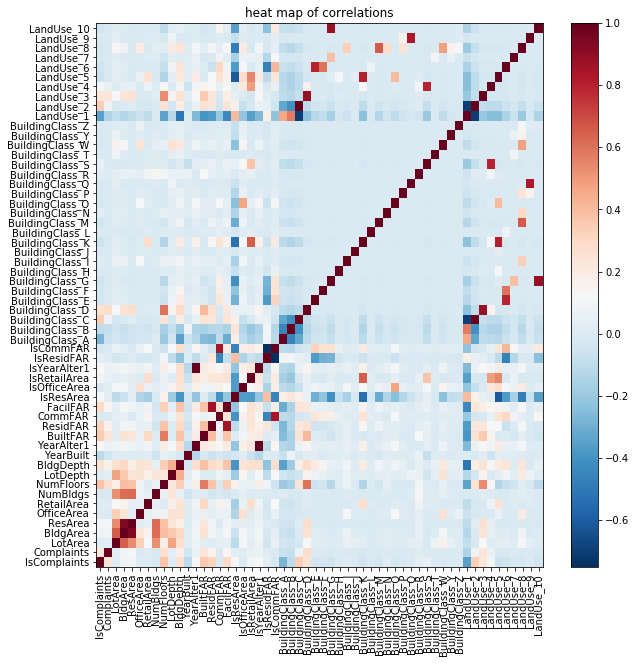

In [7]:
fig, ax = plt.subplots(figsize=(10,10))
im = ax.pcolor(AllForHeat, cmap='RdBu_r')
row_labels = df.columns; col_labels = df.columns
ax.set_xticklabels(row_labels, minor = False);ax.set_yticklabels(col_labels, minor = False)
#move ticks and labels to the center.
ax.set_xticks(np.arange(AllForHeat.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(AllForHeat.shape[0]) + 0.5, minor=False)
ax.set_title("heat map of correlations")
plt.xticks(rotation=90)
plt.colorbar(im)
plt.show()

<p style="color:Red;">Looking along the bottom 2 rows or leftmost 2 columns, there appear to be some correlations, though none super strong.  Try visualizing in a different way.</p>

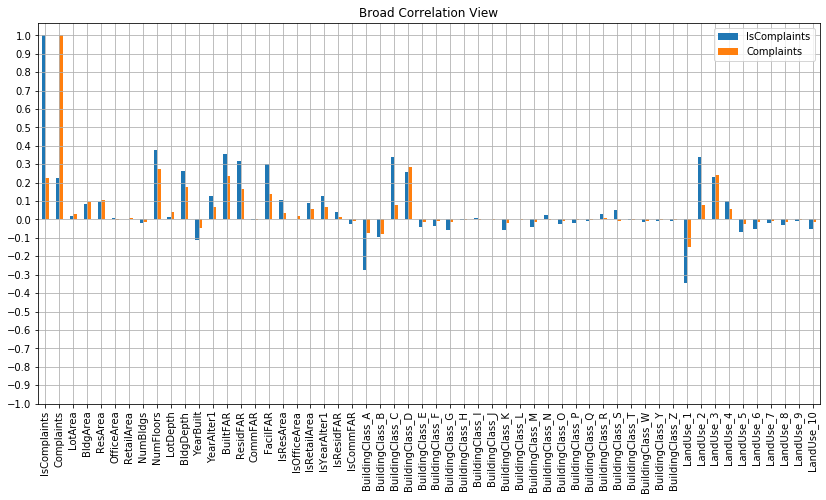

In [60]:
correlations = AllForHeat[['IsComplaints','Complaints']].plot(title="Broad Correlation View",kind='bar',grid=True,figsize=(14,7))
row_labels = df.columns
plt.xticks(np.arange(0,AllForHeat.shape[0],1),labels=row_labels,rotation=90)
plt.yticks(np.arange(-1.0,1.1,0.1))
plt.show()

<p style="color:Red;">Still a little hard to visualize which are the strongest.  Look at actual numbers.</p>

In [61]:
#See numerically what the strongest correlations are.
correlations = AllForHeat[['IsComplaints','Complaints']].abs()
correlations.loc[:,'highest'] = correlations.max(axis=1)
correlations['IsComplaints'] = AllForHeat['IsComplaints']
correlations['Complaints'] = AllForHeat['Complaints']
correlations = correlations[correlations['highest'].ge(0.20)]
correlations.sort_values(by='highest', axis=0, ascending=False, inplace=True)
correlations.drop(['highest'], axis=1, inplace=True)
print("Top Correlations")
correlations
#correlations = correlations.transpose()
#for label in correlations.columns:
#    print (label, AllForHeat[label]['IsComplaints'], AllForHeat[label]['Complaints'])

Top Correlations


,IsComplaints,Complaints
IsComplaints,1.000000,0.224490
Complaints,0.224490,1.000000
NumFloors,0.376281,0.272476
BuiltFAR,0.356718,0.236174
LandUse_1,-0.347156,-0.147378
LandUse_2,0.342127,0.079502
BuildingClass_C,0.341964,0.079674
ResidFAR,0.319841,0.163121
FacilFAR,0.300977,0.140097
BuildingClass_D,0.260713,0.287169


In [62]:
# Get the pearson correlations and confidence measures
for col in df.columns:
    pearson_coef1, p_value1 = stats.pearsonr(df[col], df['IsComplaints'])
    pearson_coef2, p_value2 = stats.pearsonr(df[col], df['Complaints'])
    if (abs(pearson_coef1) > 0.20 and p_value1 < 0.10) or (abs(pearson_coef2) > 0.20 and p_value2 < 0.10):
        print(col, pearson_coef1, p_value1, pearson_coef2, p_value2)

IsComplaints 1.0 0.0 0.22449006576870828 0.0
Complaints 0.22449006576870828 0.0 1.0 0.0
NumFloors 0.3762806738645175 0.0 0.27247601401784344 0.0
BldgDepth 0.26132517462533006 0.0 0.17867856183017278 0.0
BuiltFAR 0.3567179806675729 0.0 0.2361737661040951 0.0
ResidFAR 0.31984100334558174 0.0 0.16312061991812135 0.0
FacilFAR 0.300977078156299 0.0 0.14009703060688358 0.0
BuildingClass_A -0.27517448205890893 0.0 -0.07293306846925786 4.759024823376749e-97
BuildingClass_C 0.34196410098960217 0.0 0.0796739919019142 1.6858872848966094e-115
BuildingClass_D 0.2607133544422686 0.0 0.2871693822131084 0.0
LandUse_1 -0.34715593960008856 0.0 -0.1473784775426233 0.0
LandUse_2 0.34212650061982863 0.0 0.07950221957690067 5.216654325331181e-115
LandUse_3 0.22903072855670462 0.0 0.2394624979317007 0.0


<p style="color:Red;">Not really any "strong" correlations, but some weak ones with high confidence.  Double check the details of a few of these.</p>

In [98]:
#check a few of these to see if they are different data points that capture the same relationship.
def see_pearson(a,b):
    pearson_coef, p_value = stats.pearsonr(df[a], df[b])
    print(a, b, pearson_coef, p_value)
see_pearson('ResidFAR','FacilFAR')
see_pearson('ResidFAR','BuiltFAR')
see_pearson('FacilFAR','BuiltFAR')
see_pearson('BuildingClass_A','LandUse_1') #Single family
see_pearson('BuildingClass_C','LandUse_2') #Walk up apartments
see_pearson('BuildingClass_D','LandUse_3') #Elevator apartments
see_pearson('NumFloors','BuiltFAR') #Taller buildings have more floor area?
see_pearson('BldgDepth','BuiltFAR') #Deeper buildings have more floor area?
see_pearson('NumFloors','BldgDepth') #Taller vs Deeper?

ResidFAR FacilFAR 0.8569676636765086 0.0
ResidFAR BuiltFAR 0.3850564374033568 0.0
FacilFAR BuiltFAR 0.37429056324837645 0.0
BuildingClass_A LandUse_1 0.4655209377505204 0.0
BuildingClass_C LandUse_2 0.9984373965210063 0.0
BuildingClass_D LandUse_3 0.888767436463683 0.0
NumFloors BuiltFAR 0.5771752060596642 0.0
BldgDepth BuiltFAR 0.3788710304736768 0.0
NumFloors BldgDepth 0.3370671809911434 0.0


<p style="color:Red;">ResidFAR and FacilFAR are strongly correlated to each other.  The documentation says FAR is the "Floor Area Ratio" between the building and the LOT.  Residential and "Community Facility" seem to always be very similar to each other.  There is separate data for building category and land use category.  Similarly there is a strong correspondence between these two values.  The correlations drawn from some of these are essentially saying the same thing.  Furthermore, the ResidFAR and FacilFAR are indications of the "maximum allowable" floor area ratios.  The BuiltFAR is the ratio of the ACTUAL floor area to the lot area.</p>
<p style="color:Red;"><b>Conclusion:  </b>It Only makes sense to use one of two values that express the same information.  It doesn't make sense to concern ourselves with "maximum allowable" in cases where we also have "actual".</p>

#### Visualize strongest Pearson correlations

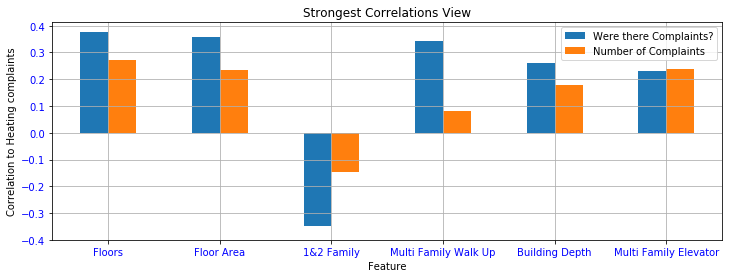

In [96]:
strongest = correlations.copy(deep=True)
strongest.drop(['IsComplaints','Complaints','FacilFAR',
                'BuildingClass_C','BuildingClass_D','BuildingClass_A',
                'ResidFAR'
                ], axis=0, inplace=True)
strongest.rename(mapper={"IsComplaints":"Were there Complaints?",
                         "Complaints":"Number of Complaints"}, axis=1, inplace=True)
strongest.rename(mapper={"LandUse_1":"1&2 Family",
                         "LandUse_2":"Multi Family Walk Up",
                         "LandUse_3":"Multi Family Elevator",
                         'NumFloors':'Floors','BuiltFAR':'Floor Area',
                         'BldgDepth':"Building Depth"}, axis=0, inplace=True)
strongest.plot(title="Strongest Correlations View",kind='bar',grid=True,figsize=(12,4))
labels = strongest.index
plt.ylabel("Correlation to Heating complaints")
plt.xlabel("Feature")
plt.xticks(np.arange(0,strongest.shape[0],1),labels=labels, rotation=0,color='blue')
plt.yticks(np.arange(-0.4,0.5,0.1),color='blue')
plt.show()

<a id="conclusion"></a>
# Concluding Remarks
---

<u><b>Yes</b></u>, the HEATING/HOT WATER complaints (question 1) reported in the BRONX borough (question 2) have an obvious relationship with the housing characteristics:
<ul>
    <li><b><u>Size</u></b>.  The larger the building, the more heating complaints.
    <ul>
        <li>Number of Floors.  <i>(Correlation:  0.37)</i>.
        <li>Floor Area.  <i>(Correlation:  0.35)</i>.
        <li>Building Depth.  <i>(Correlation:  0.26)</i>.
    </ul>
    <li><b><u>Building Type</u></b>.  Certain types are more or less prone to heating complaints than others:
    <ul>
        <li>One and two family homes.  These are less likely to have heating complaints than other building types.  <i>(Correlation:  -0.34 <u>negative</u>)</i>.
        <li>Multi family walk up buildings.  These are the most likely to have complaints.  <i>(Correlation:  0.34)</i>.
        <li>Multi family elevator buildings.  These are the second most likely to have complaints. <i>(Correlation:  0.22)</i>.
            <ul>
                <li><u><b>Additional insight</b></u>:  When there are complaints at elevator buildings it is much more likely there will be a <u>larger number of complaints per address</u> with <i>0.23 correlation</i> compared to <i>only 0.07</i> for the walk up buildings.
            </ul>
    </ul>
</ul>